In [1]:
import sys
sys.path.insert(1, '../../../../utils')
from pandas import read_csv, DataFrame, Series, concat
from studies import *
from dslabs_functions import *
from numpy import ndarray
from matplotlib.pyplot import savefig, show, figure, subplots
from imblearn.over_sampling import SMOTE


In [12]:
# Load data (already split into train/test)
train_filename = "../../data/prepared/feature-selection/flight_train_fs_both.csv"
test_filename = "../../data/prepared/feature-selection/flight_test_fs_both.csv"

train_data: DataFrame = read_csv(train_filename, na_values="")
test_data: DataFrame = read_csv(test_filename, na_values="")

target = "Cancelled"
file_tag = "flight"
metric = "recall"
lab_folder_bal = "lab3_preparation/balancing"

print(train_data.shape, test_data.shape)

(140000, 45) (60000, 45)


Minority class= True : 4583
Majority class= False : 135417
Proportion: 0.03 : 1


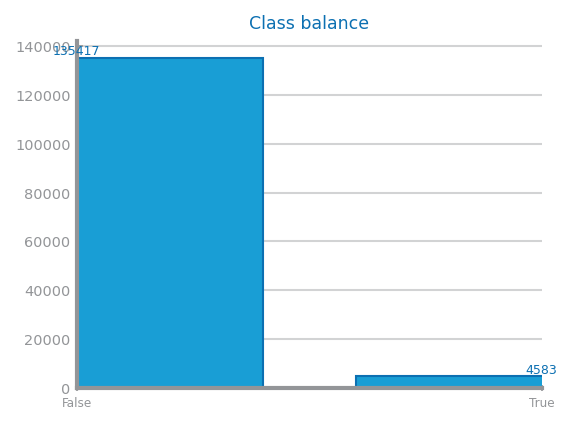

In [13]:
# Analyze class balance
target_count: Series = train_data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

In [14]:
# Separate positive and negative classes (only use train data)
train_positives: Series = train_data[train_data[target] == positive_class]
train_negatives: Series = train_data[train_data[target] == negative_class]

### Undersampling

In [6]:
approach_bal1 = "Undersampling"

# Undersample majority class to match minority class size
train_neg_sample: DataFrame = DataFrame(train_negatives.sample(len(train_positives), random_state=42))
train_under: DataFrame = concat([train_positives, train_neg_sample], axis=0)

under_target_count: Series = train_under[target].value_counts()
print("Minority class=", positive_class, ":", under_target_count[positive_class])
print("Majority class=", negative_class, ":", under_target_count[negative_class])
print("Proportion:", round(under_target_count[positive_class] / under_target_count[negative_class], 2), ": 1")
print(train_under.shape)

Minority class= True : 4583
Majority class= False : 4583
Proportion: 1.0 : 1
(9166, 45)


In [7]:
# Remove FlightDate for evaluation
train_under_eval = train_under.drop(columns=["FlightDate"], errors="ignore")
test_under_eval = test_data.drop(columns=["FlightDate"], errors="ignore")

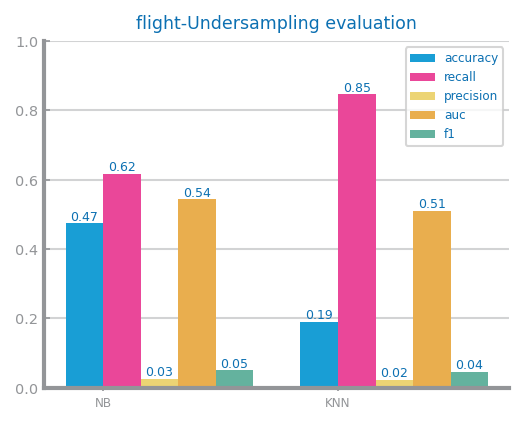

In [8]:
figure()
eval: dict[str, list] = evaluate_approach(train_under_eval, test_under_eval, target=target, metric=metric)
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_bal1} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal1}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

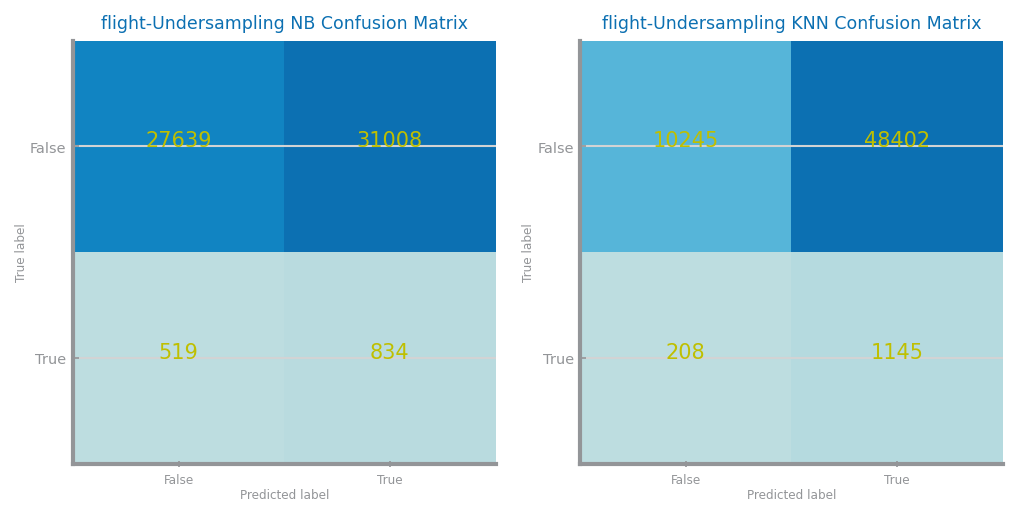

In [9]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = test_data[target].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_bal1} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_bal1} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal1}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()

### SMOTE

In [16]:
approach_bal2 = "SMOTE"

train_smote = train_data.copy()
flightdate_train: Series = train_smote.pop("FlightDate")

y = train_smote.pop(target).values

# Convert boolean columns to int to avoid SMOTE arithmetic errors
bool_cols = train_smote.select_dtypes(include=['bool']).columns
train_smote[bool_cols] = train_smote[bool_cols].astype(int)

X: ndarray = train_smote.values

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=42)
smote_X, smote_y = smote.fit_resample(X, y)

# Reconstruct DataFrame with proper columns
train_smote: DataFrame = DataFrame(smote_X, columns=train_smote.columns)
train_smote[target] = smote_y

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(train_smote.shape)

Minority class= True : 135417
Majority class= False : 135417
Proportion: 1.0 : 1
(270834, 44)


In [17]:
# Remove FlightDate from SMOTE data for evaluation
train_smote_eval = train_smote.drop(columns=["FlightDate"], errors="ignore")
test_smote_eval = test_data.drop(columns=["FlightDate"], errors="ignore")

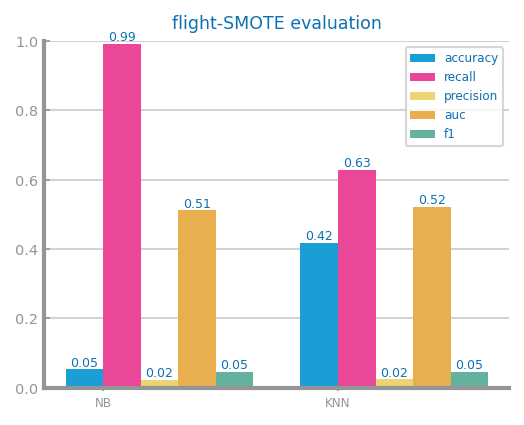

In [18]:
figure()
eval: dict[str, list] = evaluate_approach(train_smote_eval, test_smote_eval, target=target, metric=metric)
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_bal2} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal2}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

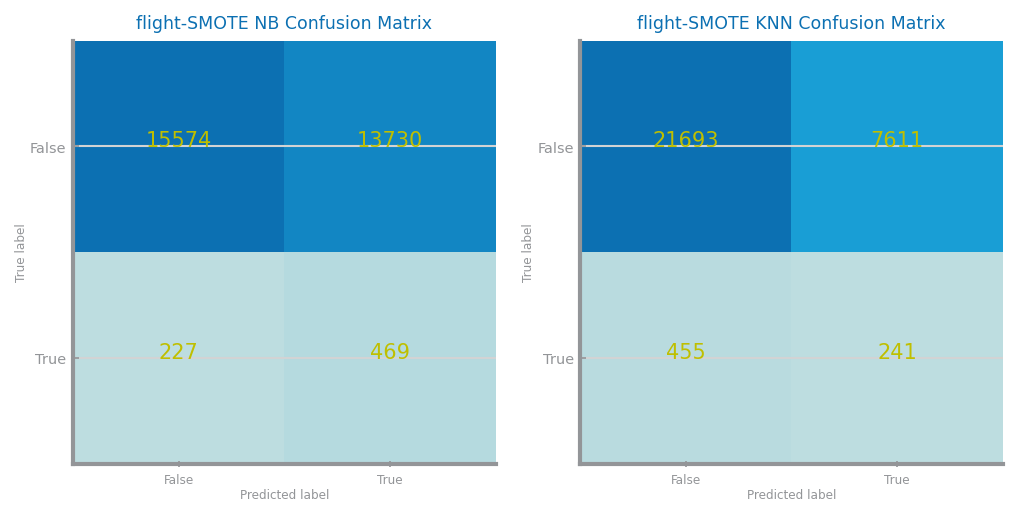

In [17]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = test_data[target].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_bal2} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_bal2} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_bal}/{file_tag}_{approach_bal2}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()

In [12]:
best_train = train_smote.copy()   # change this if undersampling or none is best
best_test  = test_data.copy()     # test is NEVER balanced

output_train_path = "../../data/prepared/balancing/flight_train_bal.csv"
output_test_path  = "../../data/prepared/balancing/flight_test_bal.csv"

print("Saving BALANCED TRAIN to:", output_train_path)
print("Saving (unchanged) TEST  to:", output_test_path)

best_train.to_csv(output_train_path, index=False)
best_test.to_csv(output_test_path,  index=False)

print("Balanced train shape:", best_train.shape)
print("Test shape:", best_test.shape)

Saving BALANCED TRAIN to: ../../data/prepared/balancing/flight_train_bal.csv
Saving (unchanged) TEST  to: ../../data/prepared/balancing/flight_test_bal.csv
Balanced train shape: (270834, 181)
Test shape: (60000, 182)
